In [ ]:
#!wget "https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz"

In [ ]:
#!tar xvzf "WISDM_ar_latest.tar.gz"

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df['z-axis'] = df['z-axis'].str.rstrip(';')
df

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,9.000000,-1.570000,1.69
1098205,19,Sitting,131623371431000,9.040000,-1.460000,1.73
1098206,19,Sitting,131623411592000,9.080000,-1.380000,1.69
1098207,19,Sitting,131623491487000,9.000000,-1.460000,1.73


In [22]:
df = df.dropna()
df.describe()

,user,timestamp,x-axis,y-axis
count,1.098208e+06,1.098208e+06,1.098208e+06,1.098208e+06
mean,1.886067e+01,3.340895e+13,6.628660e-01,7.255626e+00
std,1.021423e+01,4.944962e+13,6.849046e+00,6.746216e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01
25%,1.000000e+01,2.019110e+12,-2.870000e+00,3.170000e+00
50%,1.900000e+01,9.722677e+12,2.700000e-01,7.930000e+00
75%,2.800000e+01,4.996560e+13,4.440000e+00,1.156000e+01
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01


# Data preprocessing


In [23]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

### The reshaping

In [24]:
np.array(segments).shape

(54901, 3, 200)

In [25]:
reshaped_segments = np.asarray(segments).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [26]:
reshaped_segments.shape

(54901, 200, 3)

### Normalization

In [27]:
# reshape into keras type float32
reshaped_segments = np.array(reshaped_segments)
reshaped_segments = reshaped_segments.astype(np.float32)

In [28]:
np.max(reshaped_segments)

20.04

In [19]:
#reshaped_segments = reshaped_segments[~np.isnan(reshaped_segments)]
#np.max(reshaped_segments), np.min(reshaped_segments)

(20.04, -19.8)

In [29]:
reshaped_segments = reshaped_segments / np.max(reshaped_segments)
np.max(reshaped_segments), np.min(reshaped_segments)

(1.0, -0.9880239)

### creating train and test data

In [30]:
RANDOM_SEED = 42 # Used on top pf the article
x_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

# Creating the Model

In [31]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

[keras docs](https://keras.io/api/layers/recurrent_layers/lstm/)<br>
**inputs:** A 3D tensor with shape [batch, timesteps, feature]. <br>
-> Keras adds Input Dim automaticly (None)

In [38]:
# batch_size, timesteps, input_dim
# kernel_regularizer=l2(0.0025),
input_dim = reshaped_segments.shape[1:]
model = Sequential()
model.add(LSTM(64, input_shape=input_dim, return_sequences=True,  dropout=0.2))
model.add(LSTM(64, dropout=0.2))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(6, activation="softmax"))

from tensorflow.keras.optimizers import *

opt = Adam(lr=0.0025, clipvalue=0.5)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['categorical_accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 64)           17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 59,142
Trainable params: 59,142
Non-trainable params: 0
_________________________________________________________________


In [34]:
x_train.shape, y_train.shape

((43920, 200, 3), (43920, 6))

In [39]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=50, 
    verbose=1
)

Epoch 1/50
1373/1373 [==============================] - 22s 16ms/step - loss: 1.2473 - categorical_accuracy: 0.5009
Epoch 2/50
1373/1373 [==============================] - 22s 16ms/step - loss: 0.7245 - categorical_accuracy: 0.7371
Epoch 3/50
1373/1373 [==============================] - 22s 16ms/step - loss: 0.5171 - categorical_accuracy: 0.8070
Epoch 4/50
1373/1373 [==============================] - 22s 16ms/step - loss: 0.3816 - categorical_accuracy: 0.8517
Epoch 5/50
1373/1373 [==============================] - 22s 16ms/step - loss: 0.3044 - categorical_accuracy: 0.8850
Epoch 6/50
1373/1373 [==============================] - 22s 16ms/step - loss: 0.2310 - categorical_accuracy: 0.9155
Epoch 7/50
1373/1373 [==============================] - 22s 16ms/step - loss: 0.1898 - categorical_accuracy: 0.9331
Epoch 8/50
1373/1373 [==============================] - 22s 16ms/step - loss: 0.1690 - categorical_accuracy: 0.9396
Epoch 9/50
1373/1373 [==============================] - 22s 16ms/step - 

In [40]:
model.save_weights("Medium_LSTM_09915.h5")

In [41]:
model_hist = model.history.history

In [42]:
model_hist.keys()

dict_keys(['loss', 'categorical_accuracy'])

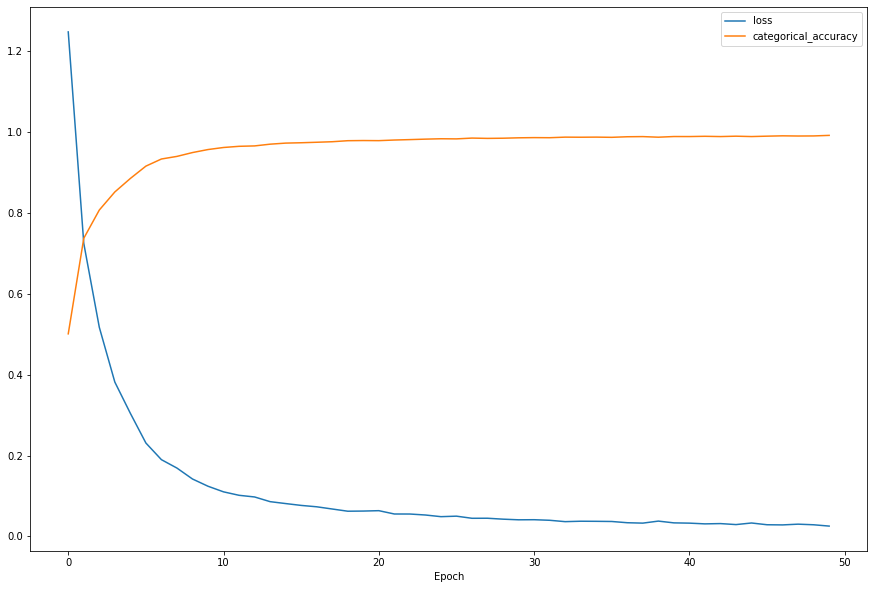

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(model_hist['loss'], label="loss")
plt.plot(model_hist['categorical_accuracy'], label="categorical_accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Prediction

In [44]:
x_test = X_test.astype(np.float32)

In [45]:
for i in range(50):
  x_sample = x_test[i]
  x_sample = x_sample.reshape(1, 200, 3)
  print("Prediction:",np.argmax(model.predict(x_sample)), "\tGround Truth:",np.argmax(y_test[i]), "\tEqual:",np.argmax(model.predict(x_sample)) == np.argmax(y_test[i]))

Prediction: 1 	Ground Truth: 1 	Equal: True
Prediction: 1 	Ground Truth: 1 	Equal: True
Prediction: 1 	Ground Truth: 1 	Equal: True
Prediction: 0 	Ground Truth: 0 	Equal: True
Prediction: 5 	Ground Truth: 5 	Equal: True
Prediction: 5 	Ground Truth: 5 	Equal: True
Prediction: 0 	Ground Truth: 0 	Equal: True
Prediction: 0 	Ground Truth: 0 	Equal: True
Prediction: 4 	Ground Truth: 4 	Equal: True
Prediction: 2 	Ground Truth: 2 	Equal: True
Prediction: 1 	Ground Truth: 1 	Equal: True
Prediction: 5 	Ground Truth: 5 	Equal: True
Prediction: 4 	Ground Truth: 4 	Equal: True
Prediction: 4 	Ground Truth: 4 	Equal: True
Prediction: 5 	Ground Truth: 5 	Equal: True
Prediction: 1 	Ground Truth: 1 	Equal: True
Prediction: 5 	Ground Truth: 5 	Equal: True
Prediction: 5 	Ground Truth: 5 	Equal: True
Prediction: 1 	Ground Truth: 1 	Equal: True
Prediction: 1 	Ground Truth: 1 	Equal: True
Prediction: 0 	Ground Truth: 0 	Equal: True
Prediction: 5 	Ground Truth: 5 	Equal: True
Prediction: 5 	Ground Truth: 5 	

# Confusion Matrix

In [46]:
y_pred = model.predict(x_test)
y_pred

array([[7.8583773e-16, 1.0000000e+00, 4.2419693e-20, 6.0848739e-21,
        2.0961632e-11, 8.4533471e-13],
       [2.4479394e-10, 9.9999571e-01, 3.4496546e-13, 3.4638152e-14,
        5.6349019e-09, 4.2411280e-06],
       [1.5703379e-10, 1.0000000e+00, 1.9124304e-18, 9.4700126e-16,
        3.5439869e-09, 4.5563184e-09],
       ...,
       [3.8224843e-07, 6.4567045e-09, 2.5895614e-11, 1.5549893e-12,
        2.4601140e-05, 9.9997509e-01],
       [3.5486183e-10, 1.1162060e-12, 3.3890607e-18, 3.1138501e-16,
        9.2748020e-10, 1.0000000e+00],
       [3.9399950e-07, 1.4855890e-10, 3.1887987e-16, 2.2953164e-16,
        9.1831280e-09, 9.9999964e-01]], dtype=float32)

In [47]:
from sklearn.metrics import confusion_matrix
y_true=np.argmax(y_test, axis=1)
confusion = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
confusion

array([[ 993,    1,    9,    9,   43,    4],
       [  24, 3397,    2,    1,    8,   15],
       [   0,    0,  574,    2,    0,    0],
       [   0,    0,    6,  430,    0,    0],
       [  26,    0,   14,   16, 1144,    8],
       [   5,    3,    1,    1,    5, 4240]])

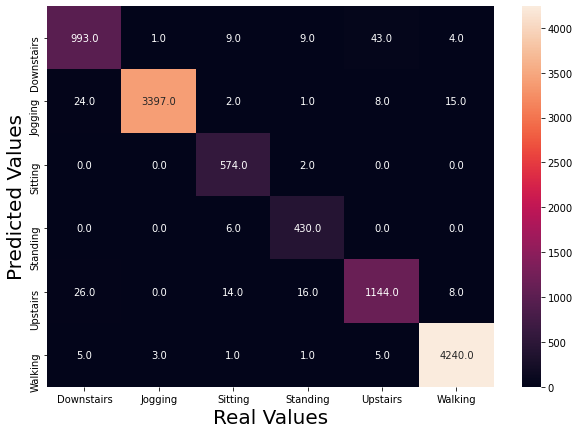

In [48]:
df_cm = pd.DataFrame(confusion, index = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'],
                  columns = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
plt.figure(figsize = (10,7))

import seaborn as sn
sn.heatmap(df_cm, annot=True, fmt=".1f")
plt.xlabel("Real Values", fontsize=20)
plt.ylabel("Predicted Values", fontsize=20)
plt.show()